# The Forecaster

## Libraries and settings

In [12]:
# Libraries
import os
import numpy as np
import pandas as pd
from sklearn import tree
import mysql.connector as sql
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder


# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Show current working directory
print(os.getcwd())

/Users/tobias/Dev/Studium/SEM3/DA/LN


## Import the wine data

In [13]:
# Connect to Wine Database
db_connection = sql.connect(host='lx26.hoststar.hosting',
                            database="ch309974_Wiicheller", user='ch309974_Wiicheller_usr', password='WiichellerUser1!')

# We assume that all values that are 0 or null don't have Ratings. That's why we exclude it.
query = 'SELECT *, wert as preis FROM wein, preis where wein.preis_id=preis.id'
df_wein_data = pd.read_sql(sql=query, con=db_connection)

df_wein_data = df_wein_data.dropna()

# Reset index
df_wein_data = df_wein_data.reset_index(drop=True)

In [14]:
df_wein_data

,id,name,alkohol_id,flasche_id,preis_id,primetime_id,rebsorte_id,region_id,weintyp_id,id,wert,preis
0,20,Amancaya Gran Reserva Bodegas Caro Mendoza,2,1,1,1,27.0,5,1,1,19.95,19.95
1,103,Burgenland Big John CuvÃ©e Reserve Scheiblhofer,2,1,1,3,27.0,21,1,1,19.95,19.95
2,134,Bio Les Alpilles IGP Moulin de LauziÃ¨res Peti...,3,1,1,4,147.0,25,1,1,19.95,19.95
3,238,ChÃ¢teau Cambon La Pelouse Haut-MÃ©doc AOC,8,1,1,67,17.0,6,1,1,19.95,19.95
4,245,ChÃ¢teau Belgrave Haut-MÃ©doc AOC Grand Cru Cl...,3,2,1,39,17.0,6,1,1,19.95,19.95
...,...,...,...,...,...,...,...,...,...,...,...,...
1855,1275,Valais AOC Humagne Rouge Fleur du RhÃ´ne,9,1,392,1,114.0,32,1,392,10.45,10.45
1856,1301,ViÃ±edo Chadwick Maipo Valley,3,1,393,61,27.0,7,1,393,355.00,355.00
1857,1341,Yecla DO Monastrell Heredad Candela,6,1,395,2,134.0,24,1,395,17.60,17.60
1858,1368,Alsace Grand Cru Pfersigberg AOP GewÃ¼rztraminer,6,1,396,4,95.0,79,2,396,14.60,14.60


## Regression Tree
See also: https://data36.com/regression-tree-python-scikit-learn

### Create train and test samples for the regression tree (train = 80%, test = 20% of the data)

In [15]:
# Create train and test samples
X_train, X_test, y_train, y_test = train_test_split(df_wein_data[['alkohol_id',
                                                        'flasche_id',
                                                        'primetime_id',
                                                        'region_id',
                                                        'weintyp_id',
                                                        'rebsorte_id']],
                                                    df_wein_data['preis'],
                                                    test_size=0.20,
                                                    random_state=42)

# Show X_train
print('X_train:')
print(X_train.head(), '\n')

# Show y_train
print('y_train:')
print(y_train.head())

X_train:
      alkohol_id  flasche_id  primetime_id  region_id  weintyp_id  rebsorte_id
244            5           1             4          1           1        200.0
1190           2           1            84         91           2        171.0
1073           3           1             1          8           1        167.0
1080           3           1             4          6           1         19.0
1230           2           1            18         32           2         67.0 

y_train:
244     14.50
1190    82.50
1073     4.95
1080     8.95
1230    22.50
Name: preis, dtype: float64


### Fit the regression tree model

In [16]:
# Create decision tree regressor object
reg = DecisionTreeRegressor(random_state=20, max_depth=5)

# Train decision tree regressor
reg = reg.fit(X_train, y_train)

# Predict the response for test dataset
y_pred = reg.predict(X_test)

### Calculate coefficient of determination (R-squared)

In [17]:
# Calculate coefficient of determination
print('R-squared:', r2_score(y_test, y_pred).round(4))

R-squared: 0.2083


### Our Evaluation

This evaluation states that we have 28% correlation. This is the worst result we received in all testing. Interesting but also sad to see.

### Print text representation of the regression tree

In [18]:
# Text representation of the regression tree
text_representation = tree.export_text(reg, 
                                       feature_names=list(X_train.columns))

# Print text_representation
print(text_representation)

|--- primetime_id <= 56.50
|   |--- primetime_id <= 35.50
|   |   |--- primetime_id <= 9.50
|   |   |   |--- alkohol_id <= 2.50
|   |   |   |   |--- rebsorte_id <= 178.00
|   |   |   |   |   |--- value: [25.99]
|   |   |   |   |--- rebsorte_id >  178.00
|   |   |   |   |   |--- value: [56.25]
|   |   |   |--- alkohol_id >  2.50
|   |   |   |   |--- alkohol_id <= 3.50
|   |   |   |   |   |--- value: [10.51]
|   |   |   |   |--- alkohol_id >  3.50
|   |   |   |   |   |--- value: [22.52]
|   |   |--- primetime_id >  9.50
|   |   |   |--- region_id <= 8.50
|   |   |   |   |--- alkohol_id <= 6.50
|   |   |   |   |   |--- value: [60.58]
|   |   |   |   |--- alkohol_id >  6.50
|   |   |   |   |   |--- value: [31.44]
|   |   |   |--- region_id >  8.50
|   |   |   |   |--- alkohol_id <= 8.50
|   |   |   |   |   |--- value: [33.78]
|   |   |   |   |--- alkohol_id >  8.50
|   |   |   |   |   |--- value: [17.01]
|   |--- primetime_id >  35.50
|   |   |--- region_id <= 8.50
|   |   |   |--- weintyp

### Vizualizing the regression tree

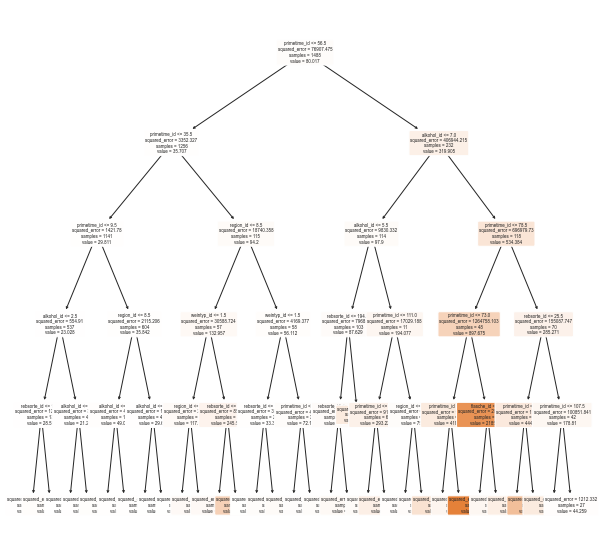

In [19]:
fig = plt.figure(figsize=(10,10))
_ = tree.plot_tree(reg, 
                   feature_names=list(X_train.columns),  
                   class_names=['price'],
                   filled=True,
                   fontsize=4.5,
                   rounded=True)

## Random Forest Regression
For details see: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

### Create train and test samples for the random forest (train = 80%, test = 20% of the data)

In [20]:
# Create train and test samples (the names X2_ and y2_ were used because X_ and y_ were already used above)
X2_train, X2_test, y2_train, y2_test = train_test_split(df_wein_data[['alkohol_id',
                                                                      'flasche_id',
                                                                      'primetime_id',
                                                                      'region_id',
                                                                      'weintyp_id',
                                                                      'rebsorte_id']],
                                                        df_wein_data['preis'],
                                                            test_size=0.20, 
                                                            random_state=42)
# Show X2_train
print('X2_train:')
print(X2_train.head(), '\n')

# Show y2_train
print('y2_train:')
print(y2_train.head())

X2_train:
      alkohol_id  flasche_id  primetime_id  region_id  weintyp_id  rebsorte_id
244            5           1             4          1           1        200.0
1190           2           1            84         91           2        171.0
1073           3           1             1          8           1        167.0
1080           3           1             4          6           1         19.0
1230           2           1            18         32           2         67.0 

y2_train:
244     14.50
1190    82.50
1073     4.95
1080     8.95
1230    22.50
Name: preis, dtype: float64


### Fit the Random Forest Regression

In [21]:
X, y = make_regression(n_features=4, n_informative=2,
                       random_state=5, shuffle=False)


reg_rf = RandomForestRegressor(n_estimators=500, 
                               max_depth=10, 
                               random_state=5)
reg_rf.fit(X2_train, y2_train)

# Calculate coefficient of determination (R-squared)
print('R-squared:', reg_rf.score(X2_test, y2_test).round(4))

R-squared: 0.5584


### Our Evaluation

This evaluation states that we have 55% correlation. This is interesting to see since the Forest regression gave a better correlation. This is suprising since we had more data in the second variation. Maybe we could try a mix of Variation in Version 3 but this would nuke the scope of the project.

### Show feature importance

Index(['primetime_id', 'alkohol_id', 'rebsorte_id', 'flasche_id', 'region_id',
       'weintyp_id'],
      dtype='object')
[0.62784728 0.1216585  0.10411537 0.07305104 0.06457972 0.00874809]


<AxesSubplot:ylabel='features'>

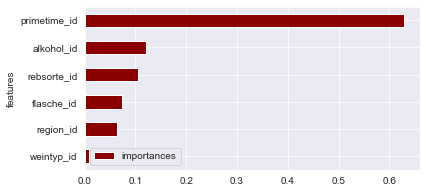

In [22]:
cols = X2_train.columns

# Derive feature importance from random forest
importances = reg_rf.feature_importances_
std         = np.std([tree.feature_importances_ for tree in reg_rf.estimators_], axis=0)
indices     = np.argsort(importances)[::-1]

# Print col-names and importances-values
print( cols[indices] )
print( importances[indices] )

# Barplot with feature importance
df_fi = pd.DataFrame({'features':cols,'importances': importances})
df_fi.sort_values('importances', inplace=True)
df_fi.plot(kind='barh', 
           y='importances', 
           x='features', 
           color='darkred', 
           figsize=(6,3))

Yes the importance changes since area was deleted, other variables are now more important and leading.